/local_scratch/slurm.1235075/ipykernel_2740519/3438292188.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 70.9MB/s]


Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 32.5MB/s]

Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 19.8MB/s]


Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.02MB/s]


Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


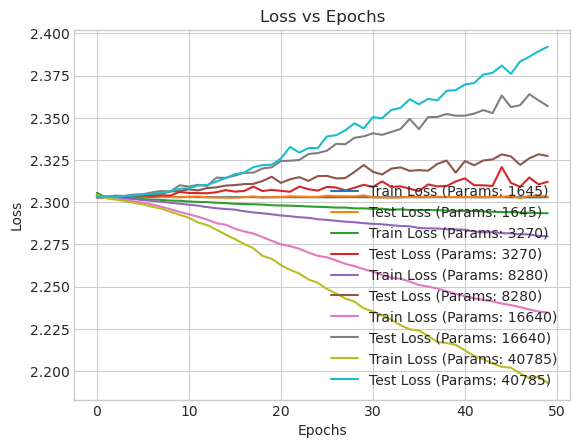

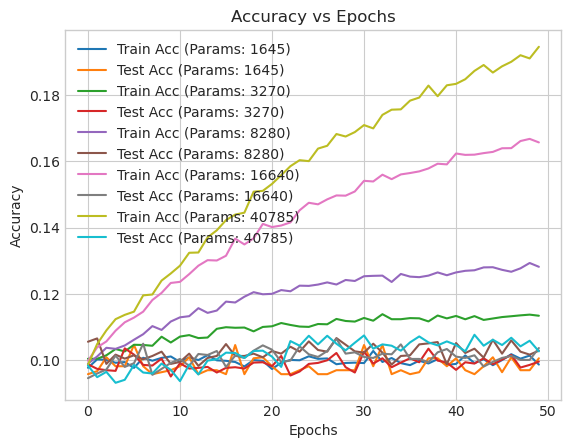

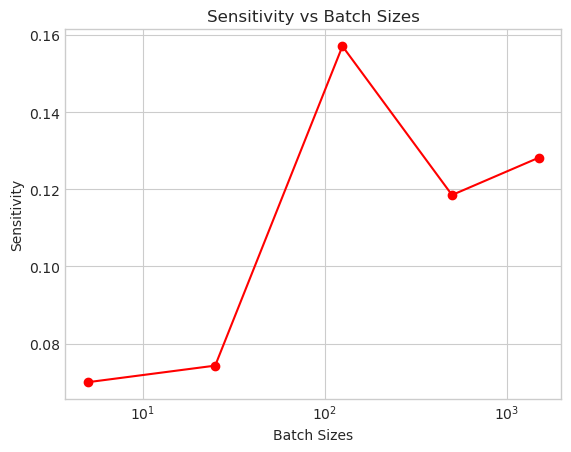

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

# Set up plotting style
plt.style.use('seaborn-whitegrid')

# Grab MNIST dataset
trainingSet = datasets.MNIST('./MNIST', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
testingSet = datasets.MNIST('./MNIST', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

# Randomize labels for training and testing (for first use case)
randomLabelsTrain = torch.tensor(np.random.randint(0, 10, len(trainingSet)))
trainingSet.targets = randomLabelsTrain
randomLabelsTest = torch.tensor(np.random.randint(0, 10, len(testingSet)))
testingSet.targets = randomLabelsTest

# Define DataLoaders with different batch sizes
batchSizes = [5, 25, 125, 500, 1500]
trainLoaders = [torch.utils.data.DataLoader(trainingSet, batch_size=bs, shuffle=True) for bs in batchSizes]
testLoaders = [torch.utils.data.DataLoader(testingSet, batch_size=bs, shuffle=True) for bs in batchSizes]

# Define neural network model class
class RandomNN(nn.Module):
    def __init__(self, hidden1, hidden2):
        super().__init__()
        self.fc1 = nn.Linear(784, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate multiple models with varying parameter counts
hidden_sizes = [(2, 5), (4, 8), (10, 20), (20, 30), (50, 25)]
models = [RandomNN(h1, h2) for h1, h2 in hidden_sizes]

# Calculate number of parameters for each model
def calcParams(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model_params = [calcParams(model) for model in models]

# Set up optimization and loss functions
costFunc = nn.CrossEntropyLoss()
optimizers = [optim.Adam(model.parameters(), lr=0.001) for model in models]

# Training loop
EPOCHS = 50
trainLoss = [[] for _ in models]
testLoss = [[] for _ in models]
trainAccuracy = [[] for _ in models]
testAccuracy = [[] for _ in models]

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")

    for model, optimizer, trainLoader, testLoader, modelTrainLoss, modelTestLoss, modelTrainAcc, modelTestAcc in zip(
        models, optimizers, trainLoaders, testLoaders, trainLoss, testLoss, trainAccuracy, testAccuracy):
        
        # Training
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0
        for inputs, labels in trainLoader:
            inputs = inputs.view(-1, 784)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = costFunc(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            correct_train += (outputs.argmax(dim=1) == labels).sum().item()
            total_train += len(labels)
        modelTrainLoss.append(total_train_loss / len(trainLoader))
        modelTrainAcc.append(correct_train / total_train)

        # Testing
        model.eval()
        total_test_loss = 0
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for inputs, labels in testLoader:
                inputs = inputs.view(-1, 784)
                outputs = model(inputs)
                loss = costFunc(outputs, labels)
                total_test_loss += loss.item()
                correct_test += (outputs.argmax(dim=1) == labels).sum().item()
                total_test += len(labels)
        modelTestLoss.append(total_test_loss / len(testLoader))
        modelTestAcc.append(correct_test / total_test)

# Plot results: Training/Test Loss and Accuracy vs Parameters
plt.figure()
for i, params in enumerate(model_params):
    plt.plot(range(EPOCHS), trainLoss[i], label=f"Train Loss (Params: {params})")
    plt.plot(range(EPOCHS), testLoss[i], label=f"Test Loss (Params: {params})")
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure()
for i, params in enumerate(model_params):
    plt.plot(range(EPOCHS), trainAccuracy[i], label=f"Train Acc (Params: {params})")
    plt.plot(range(EPOCHS), testAccuracy[i], label=f"Test Acc (Params: {params})")
plt.title("Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Sensitivity Analysis (Gradient Norm)
sensitivities = []
for model in models:
    fNormAll = 0
    counter = 0
    for p in model.parameters():
        if p.grad is not None:
            fNormAll += torch.linalg.norm(p.grad).item()
            counter += 1
    sensitivities.append(fNormAll / counter if counter > 0 else 0)

plt.figure()
plt.plot(batchSizes, sensitivities, 'r-o')
plt.title("Sensitivity vs Batch Sizes")
plt.xlabel("Batch Sizes")
plt.ylabel("Sensitivity")
plt.xscale("log")
plt.show()
